# Leitura e Tratamento dos Dados
Esse notebook será utilizado para preparar os dados a serem utilizados pelos métodos de recomendação. 
Seria uma pré-etapa, que só precisa ser refeita se os dados brutos mudarem.

Os dados são lidos do formato `.jsonl` e mesclados em um único arquivo parquet (um para avaliações e um para metadados)

## Importação de Bibliotecas Utilizadas

In [ ]:
import pandas as pd
import os
import gc
import glob
from pyarrow import parquet as pq
import pyarrow as pa
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Variáveis / Constantes

In [ ]:
#Dataframe para ratings
dfRatings = None

#Dataframe para infos
dfMeta = None 

# Pasta raiz para os arquivos de dados
root_path = "../data/"

# Pasta de entrada para os arquivos jsonl
input_path = os.path.join(root_path, 'datasets_fonte')

# Pasta de saída para arquivos tratados
output_path = os.path.join(root_path,'datasets_pos_tratamento')

# Quantidade mínima de reviews de um usuário a ser utilizado como vizinho
qtdMinReviewsPerUser = 4

# Quantidade mínima de reviews de um produto a ser considerado
qtdMinReviewsPerProduct = 10

# Index do arquivo atualment lido. Utilizado para a etapa de verificação manual, e ativada pela variável verify_file_index
verify_file_index = False
current_file_index = 5

# Quantidade de linhas esperadas a serem lidas nos arquivos de metadados e avaliações
goal_total_lines_meta = 100_000 
goal_total_lines_ratings = 1_000_000 

## Meta dados

### Pré Processamento dos Dados

#### Filtragem de colunas utilizadas

In [ ]:
def selectColumns(dfMeta):
    """Seleciona as colunas a serem utilizadas no DataFrame de metadados.

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    used_columns = [ 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'store', 'categories', 'details', 'parent_asin' ]

    dfMeta = dfMeta[used_columns]
    
    return dfMeta

#### Renomeando as colunas para melhor visualização

In [ ]:
def columnsRename(dfMeta):
    """Traduz os nomes das colunas do DataFrame de metadados para português.

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    dfMeta.rename(columns = {'parent_asin': 'IDENTIFICADOR', 
                             'title': 'TITULO', 
                             'average_rating': 'MEDIA_VOTOS', 
                             'rating_number': 'QTD_AVALIACOES', 
                             'features': 'CARACTERISTICAS', 
                             'description': 'DESCRICAO', 
                             'price': 'PRECO',
                             'store': 'LOJA', 
                             'details': 'DETALHES', 
                             'categories': 'CATEGORIAS'},
                  inplace=1)
    
    return dfMeta

#### Tratativas de valores nulos

In [ ]:
def removeNullLines(dfMeta):
    """Remove linhas onde todos os valores são nulos

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    return dfMeta.dropna(axis=0, how="all")

#### Filtragem de elementos para precisão

In [ ]:
def filterElements(dfMeta, qtdMinReviewsPerProduct):
    """Filtra os produtos no DataFrame de metadados para manter apenas aqueles com uma quantidade mínima de avaliações.

    Args:
        dfMeta (pd.DataFrame)
        qtdMinReviewsPerProduct (int): Quantidade mínima de avaliações que um produto deve ter para ser incluído no DataFrame.

    Returns:
        pd.DataFrame
    """
    
    # Ajustando o df para conter apenas produtos com mais de X avaliações
    dfMeta = dfMeta[dfMeta['QTD_AVALIACOES'] > qtdMinReviewsPerProduct]
    
    return dfMeta

#### Tratativa de Outliers

In [ ]:
def treatOutliers(dfMeta, cols='PRECO'):
    """ Elimina outliers de uma coluna específica do DataFrame de metadados, mantendo valores nulos ou dentro dos limites definidos pelo IQR (Intervalo Interquartil).

    Args:
        dfMeta (pd.DataFrame)
        cols (str, optional): Colunas a serem convertidas para o IQR. Valor padrão é 'PRECO'.

    Returns:
        pd.DataFrame
    """
    
    # Garante que a coluna esteja no formato numérico
    dfMeta[cols] = pd.to_numeric(dfMeta[cols], errors='coerce')

    q1 = dfMeta[cols].quantile(0.25)
    q3 = dfMeta[cols].quantile(0.99)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Mantém valores nulos ou dentro dos limites
    return dfMeta[dfMeta[cols].isna() | ((dfMeta[cols] >= limite_inferior) & (dfMeta[cols] <= limite_superior))]


#### Truncando as casas

In [ ]:
def truncateColumns(dfMeta):
    """Trunca os valores da coluna 'PRECO' do DataFrame de metadados para 2 casas decimais.

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    # Arredondando o preço para 2 casas decimais
    dfMeta['PRECO'] = dfMeta['PRECO'].round(2)  
    
    return dfMeta

#### Tratativas de valores faltantes

In [ ]:
def getMean(dfMeta, target, group=None):
    """Calcula a média de uma coluna específica no DataFrame de metadados, podendo agrupar por outra coluna.

    Args:
        dfMeta (pd.DataFrame)
        target (str): Nome da coluna para a qual a média será calculada.
        group (str, optional): Nome da coluna utilizada para o agrupamento. Default é None.

    Returns:
        pd.DataFrame
    """

    # Com agrupamento
    if group is not None:
        return dfMeta.groupby(group)[target].transform('mean').round(2)
    # Sem agrupamento
    else:
        return round(dfMeta[target].mean(), 2)

In [ ]:
def check_empty_categories(x, default_value):
    """Função auxiliar, verifica se uma variável está vazia ou nula e retorna um valor padrão.

    Args:
        x 
        default_value: Valor padrão a ser retornado se x estiver vazio ou nulo.

    Returns:
        x
    """
    
    # None ou NaN 
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return [default_value]

    # Lista vazia
    if isinstance(x, list) and len(x) == 0:
        return [default_value]

    # Numpy array vazio
    if isinstance(x, np.ndarray) and x.size == 0:
        return [default_value]

    # String vazia ou só espaços
    if isinstance(x, str) and x.strip() == "":
        return [default_value]

    # Qualquer outra forma de NaN que escapou
    try:
        if pd.isna(x):
            return [default_value]
    except Exception:
        pass

    # Caso válido
    return x


In [ ]:
def fillMissingValues(dfMeta, category=None):
    """Preenche valores ausentes no DataFrame de metadados, especialmente na coluna 'LOJA' e 'PRECO', e ajusta as categorias.

    Args:
        dfMeta (pd.DataFrame): _description_
        category (string, optional): Categoria padrão a ser utilizada para preenchimento. Defaults é não substituir (None)

    Returns:
        pd.DataFrame
    """
    
    # Preenche valores ausentes na coluna 'LOJA' com o valor mais frequente
    dfMeta['LOJA'] = dfMeta['LOJA'].fillna(dfMeta['LOJA'].mode()[0])
    
    # Preenche valores ausentes na coluna 'CATEGORIAS' com uma lista contendo a categoria padrão, se fornecida
    if category is not None:
        dfMeta['CATEGORIAS'] = dfMeta['CATEGORIAS'].apply(lambda x: check_empty_categories(x, category))

    # Salva o formato original da coluna
    categorias_original = dfMeta['CATEGORIAS'].copy()

    # Converte para string apenas para aplicar o groupby
    dfMeta['CATEGORIAS'] = dfMeta['CATEGORIAS'].apply(lambda x: str(x) if isinstance(x, list) else x)

    # Tratamento especial para price
    # Agrupa por 'categorias' para calcular a média de 'price'
    # Substitui valores nulos em 'price' pela média calculada no agrupamento
    dfMeta.fillna({'PRECO': getMean(dfMeta, 'PRECO', 'CATEGORIAS')}, inplace=True)
    
    #Caso tenha sobrado alguma sem a média de categoria, utiliza a média geral
    dfMeta.fillna({'PRECO': getMean(dfMeta, 'PRECO')}, inplace=True) 
    
    # Restaura o formato original (lista) da coluna
    dfMeta['CATEGORIAS'] = categorias_original
    
    return dfMeta

### Convertendo listas para string

In [ ]:
def convertListsToString(dfMeta):
    """Converte as colunas de listas para string

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    dfMeta['CARACTERISTICAS'] = dfMeta['CARACTERISTICAS'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    dfMeta['DESCRICAO'] = dfMeta['DESCRICAO'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    dfMeta['DETALHES'] = dfMeta['DETALHES'].apply(lambda x: ', '.join(x) if isinstance(x, dict) else x)
    dfMeta['CATEGORIAS'] = dfMeta['CATEGORIAS'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    
    return dfMeta

### Função geral do tratamento

In [ ]:
def treatData(file, lines):
    """Função principal para ler e tratar os dados de um arquivo JSON.

    Args:
        file (str): Caminho do arquivo no sistema a ser lido
        lines (int): Quantidade de linhas esperadas a serem lidas do arquivo
    Returns:
        pd.DataFrame
    """
    
    # Lê no máximo 'lines*1.2' linhas do arquivo. Um pouco de excesso para garantir uma menor falta de linhas após o tratamento
    dfMeta = pd.read_json(file, encoding='utf-8', lines=True, nrows=int(lines*1.2))
    
    # Chamando as funções de tratamento dos dados
    main_category = dfMeta['main_category'].mode()[0]
    dfMeta = selectColumns(dfMeta)
    # Caso o dataframe tenha alguma das colunas necessárias completamente nulas, retorna um dataframe vazio
    if dfMeta.isnull().all().any():
        return pd.DataFrame()
    dfMeta = columnsRename(dfMeta)
    dfMeta = removeNullLines(dfMeta)
    dfMeta = filterElements(dfMeta, qtdMinReviewsPerProduct)
    dfMeta = treatOutliers(dfMeta)
    dfMeta = truncateColumns(dfMeta)
    dfMeta = fillMissingValues(dfMeta, category=main_category)
    dfMeta = convertListsToString(dfMeta)
    
    return dfMeta

### Leitura e verificação dos Datasets (Análise Exploratória)

#### Modelagem do Schema do parquet

In [ ]:
def parquet_schema():
    """Garante consistência de tipos entre chunks

    Returns:
        pyarrow.schema
    """
    
    
    return pa.schema([
        ('IDENTIFICADOR', pa.string()),
        ('TITULO', pa.string()),
        ('MEDIA_VOTOS', pa.float32()),
        ('QTD_AVALIACOES', pa.uint32()),
        ('CARACTERISTICAS', pa.string()),
        ('DESCRICAO', pa.string()),
        ('PRECO', pa.float32()),
        ('LOJA', pa.string()),
        ('DETALHES', pa.string()),
        ('CATEGORIAS', pa.string())
    ])

In [17]:
#  Criar estrutura de arquivo Parquet vazio
schema = parquet_schema()

#### Criação de pastas necessárias e identificação dos arquivos

In [18]:
os.makedirs(output_path, exist_ok=True)

meta_files = [os.path.join(input_path, file) for file in os.listdir(input_path) if "meta" in file.lower()]

#### Determinando o número de linhas a serem lidas para cada arquivo

In [19]:
# Para começar irei contar a quantidade de linhas em cada arquivo. Assim distribuirei quantas linhas terá o novo arquivo

sizes = []

# Itera sobre cada jsonl bruto
for idx, file in enumerate(meta_files):
    
    if verify_file_index and idx != current_file_index:
        continue

    with open(file, 'r', encoding='utf-8') as f:
        lines = sum(1 for _ in f) - 1  # -1 para ignorar header
        sizes.append(lines)
    
total_lines = sum(sizes)
total_lines

KeyboardInterrupt: 

In [ ]:
# A seguir, será definida uma proporção para utilização de cada arquivo, de acordo seu tamanho, na população do novo arquivo	

proportions = [tam / total_lines for tam in sizes]
prop_idx = 0

lines_by_file = {}
for idx, file in enumerate(meta_files):
    if verify_file_index and idx != current_file_index:
        continue
    # Supondo que 'proportions' já foi calculado para os arquivos lidos
    lines_by_file[file] = int(proportions[prop_idx] * goal_total_lines_meta)
    prop_idx += 1

print(lines_by_file)

{'E:/tcc-everson_martinez/datasets_fonte\\All_Beauty_meta.jsonl': 526, 'E:/tcc-everson_martinez/datasets_fonte\\Amazon_Fashion_meta.jsonl': 3863, 'E:/tcc-everson_martinez/datasets_fonte\\Appliances_meta.jsonl': 441, 'E:/tcc-everson_martinez/datasets_fonte\\Automotive_meta.jsonl': 9367, 'E:/tcc-everson_martinez/datasets_fonte\\Baby_Products_meta.jsonl': 1018, 'E:/tcc-everson_martinez/datasets_fonte\\Books_meta.jsonl': 20801, 'E:/tcc-everson_martinez/datasets_fonte\\CDs_and_Vinyl_meta.jsonl': 3282, 'E:/tcc-everson_martinez/datasets_fonte\\Cell_Phones_and_Accessories_meta.jsonl': 6025, 'E:/tcc-everson_martinez/datasets_fonte\\Electronics_meta.jsonl': 7529, 'E:/tcc-everson_martinez/datasets_fonte\\Grocery_and_Gourmet_Food_meta.jsonl': 2821, 'E:/tcc-everson_martinez/datasets_fonte\\Health_and_Household_meta.jsonl': 3729, 'E:/tcc-everson_martinez/datasets_fonte\\Health_and_Personal_Care_meta.jsonl': 281, 'E:/tcc-everson_martinez/datasets_fonte\\Home_and_Kitchen_meta.jsonl': 17469, 'E:/tcc-ev

#### Leitura

In [ ]:
# Leitura de dataset 1 (Informações)

temp_dir = os.path.join(output_path, 'temp_parquets')
os.makedirs(temp_dir, exist_ok=True)
dfMeta = pd.DataFrame()

for idx, file in enumerate(meta_files):
    if verify_file_index and idx != current_file_index:
        continue
    
    chunk = treatData(file, lines_by_file[file])
    
    if chunk.empty:
        print()(f"Arquivo {file} está vazio ou não contém dados válidos após o tratamento.")
        continue
    
    chunk.to_parquet(os.path.join(temp_dir, f'chunk_{os.path.splitext(os.path.basename(file))[0]}.parquet'),
                     index=False, engine='pyarrow', schema=schema, compression='snappy')
    
    # Liberar memória
    del chunk
    gc.collect()

### Exportação

In [ ]:
# Lê todos os parquets temporários e concatena
parquet_files = glob.glob(os.path.join(temp_dir, '*.parquet'))
tables = [pq.read_table(f) for f in parquet_files]
full_table = pa.concat_tables(tables)
del tables
gc.collect()

df_temp = full_table.to_pandas()
del full_table
gc.collect()

# Remove duplicatas com base na coluna 'IDENTIFICADOR'
df_temp = df_temp.drop_duplicates(subset='IDENTIFICADOR', keep='first')

n_sample = min(goal_total_lines_meta, len(df_temp))
dfMeta = df_temp.sample(n=n_sample, random_state=42)
del df_temp
gc.collect()

dfMeta.to_parquet(os.path.join(output_path, 'meta_tratados.parquet'), engine='pyarrow')

# Limpeza
shutil.rmtree(temp_dir)

### Verificação
Verificação dos dados lidos de arquivos meta

In [ ]:
# Lê o arquivo Parquet
#dfMeta = pd.read_parquet(os.path.join(output_path, 'meta_tratados.parquet'), engine="pyarrow")

In [ ]:
dfMeta.head()

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS
52011,B08V9799ZG,"Electric Can Opener, Restaurant Can Opener, Fu...",2.7,23,,,15.040000,W-Dragon,"Date First Available, Color, Material, Brand, ...","Home & Kitchen, Kitchen & Dining, Kitchen Uten..."
67694,B09JGJ7D1S,"PAPAISON Roller Skates for Women and Men, Delu...",4.6,720,【RETRO STYLE 】 Classic high top double-row rol...,,79.989998,PAPAISON,"Size, Color, Brand, Wheel Material, Wheel Type...","Sports & Outdoors, Sports, Skates, Skateboards..."
3050,B06XB6LF6Y,Dewhel Sport Front Bumper Tow Hook License Pla...,3.4,166,"High quality aluminum Tow hook License Plate,B...",Tow Hook License Plate Fitments:2000-2009 Hond...,20.990000,DEWHEL,"Manufacturer, Brand, Item Weight, Package Dime...","Automotive, Exterior Accessories, License Plat..."
66635,B07RSM5PRD,JR Studio 3x5 inch Yellow Combat Vet Tab Shape...,4.2,13,Size: Check Item title - Professionally made i...,,4.990000,JR Studio,"Brand, Color, Room Type, Recommended Uses For ...","Sports & Outdoors, Fan Shop, Auto Accessories,..."
64560,B08KXF2S4V,"Horsemen's Pride Horse Feed Tub, Small, 18 Qua...",4.4,36,This small/mini feed tub measures 14 inches ac...,The Small Feed Tub measures 14 inches across (...,32.590000,Jolly Pets,"Product Dimensions, Item model number, Date Fi...","Pet Supplies, Horses, Stable Supplies, Feeding..."


In [ ]:
dfMeta.tail()

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS
37194,B082B8WPW5,"THRRLY Airpods Case, Girls Cute Clear Airpods ...",4.3,85,【Compatibility】This case designed for Airpods ...,"Compatibity:, Compatible with Apple Airpods 1s...",11.980000,THRRLY,"Package Dimensions, Item Weight, Manufacturer,...","Electronics, Headphones, Earbuds & Accessories..."
6265,B09G6QB78V,MAYASAF EGR Valve EGV598 1998 99 2000 01 02 03...,4.1,13,【Part Fitment】For 1998-2004 Pathfinder;Frontie...,,44.990002,MAYASAF,"Manufacturer, Part Number, Item Weight, Packag...","Automotive, Replacement Parts, Exhaust & Emiss..."
54886,B08LXSPQZC,Avana Chaise Lounge Chair for Stretching and R...,4.2,52,COMFY & UNIQUE -- Comfortable and unique style...,,439.000000,Avana,"Color, Brand, Product Dimensions, Style, Speci...","Home & Kitchen, Furniture, Living Room Furnitu..."
860,B08PMQJRYQ,NIXON District Beanie,4.2,11,"100% Acrylic, Made in USA or Imported, Machine...",The primary materials that compose this produc...,16.000000,NIXON,"Department, Date First Available, Manufacturer",AMAZON FASHION
15795,1101908211,Poems from Greek Antiquity (Everyman's Library...,4.7,40,A beautiful Pocket Poet selection of short poe...,"About the Author, PAUL QUARRIE, author of, Win...",15.950000,Paul Quarrie (Editor),"Publisher, Language, Hardcover, ISBN 10, ISBN ...","Books, Literature & Fiction, Poetry"


In [ ]:
dfMeta.isnull().sum()

IDENTIFICADOR      0
TITULO             0
MEDIA_VOTOS        0
QTD_AVALIACOES     0
CARACTERISTICAS    0
DESCRICAO          0
PRECO              0
LOJA               0
DETALHES           0
CATEGORIAS         0
dtype: int64

In [ ]:
dfMeta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75693 entries, 52011 to 15795
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IDENTIFICADOR    75693 non-null  object 
 1   TITULO           75693 non-null  object 
 2   MEDIA_VOTOS      75693 non-null  float32
 3   QTD_AVALIACOES   75693 non-null  uint32 
 4   CARACTERISTICAS  75693 non-null  object 
 5   DESCRICAO        75693 non-null  object 
 6   PRECO            75693 non-null  float32
 7   LOJA             75693 non-null  object 
 8   DETALHES         75693 non-null  object 
 9   CATEGORIAS       75693 non-null  object 
dtypes: float32(2), object(7), uint32(1)
memory usage: 5.5+ MB


In [ ]:
dfMeta[dfMeta['IDENTIFICADOR'] == 'B099K7YMYH']

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS


In [ ]:
dfMeta[dfMeta['PRECO'].isnull()].head()

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS


In [ ]:
len(dfMeta)

75693

In [ ]:
dfMeta['PRECO'].mean()

40.08669

In [ ]:
dfMeta['PRECO'].isnull().mean()

0.0

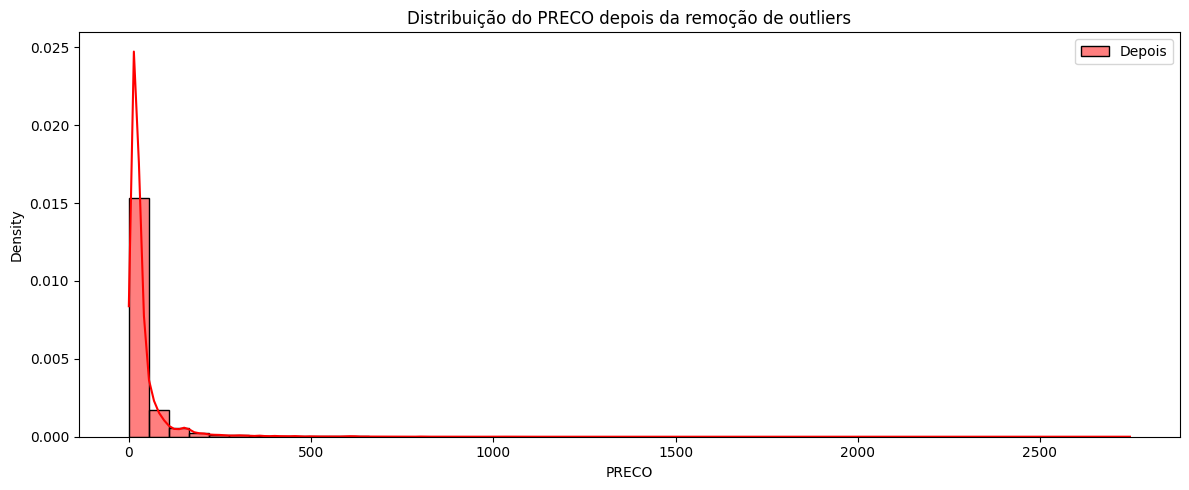

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(dfMeta['PRECO'], bins=50, color='red', label='Depois', stat='density', kde=True)
plt.title('Distribuição do PRECO depois da remoção de outliers')
plt.legend()
plt.tight_layout()
plt.show()

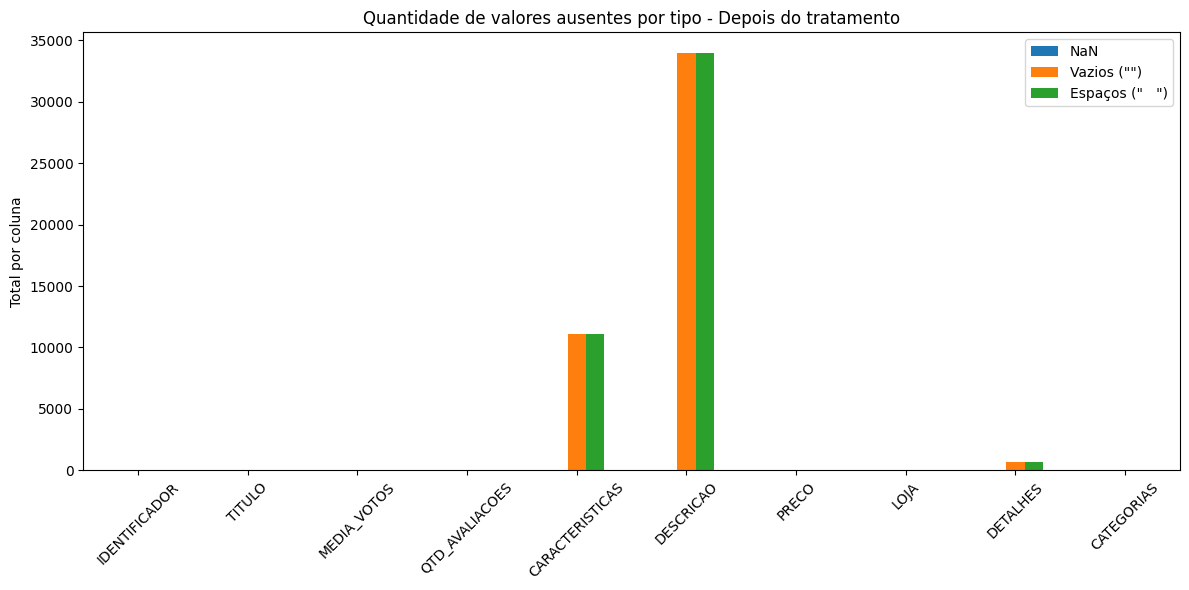

In [ ]:
# Contagem de NaN reais
nulls_nan = dfMeta.isna().sum()

# Contagem de strings vazias ("")
nulls_empty_string = dfMeta.apply(lambda col: (col == '').sum() if col.dtype == 'object' else 0)

# Contagem de strings com apenas espaços ("   ")
nulls_whitespace = dfMeta.apply(lambda col: col.apply(lambda x: isinstance(x, str) and x.strip() == '').sum() if col.dtype == 'object' else 0)

df_nulls = pd.DataFrame({
    'NaN': nulls_nan,
    'Vazios ("")': nulls_empty_string,
    'Espaços ("   ")': nulls_whitespace
})

df_nulls.plot(kind='bar', figsize=(12, 6))
plt.title('Quantidade de valores ausentes por tipo - Depois do tratamento')
plt.ylabel('Total por coluna')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


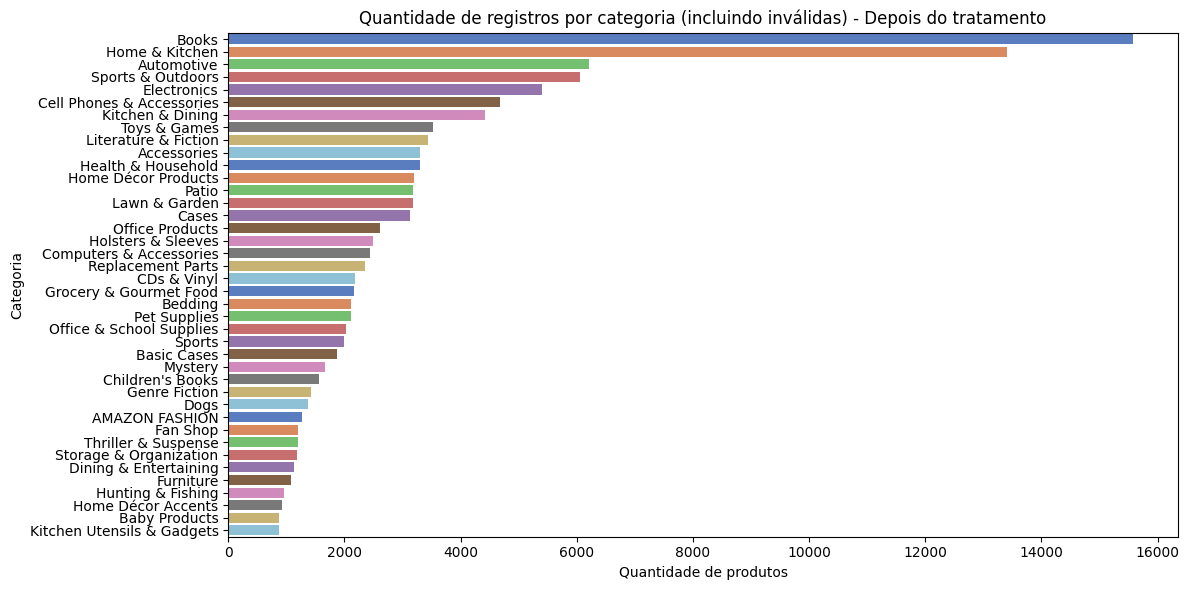

In [ ]:
def is_invalida(s):
    s = s.strip()
    return s == '' or all(c.strip() == '' for c in s.split(','))

col = dfMeta['CATEGORIAS'].fillna('')

validas = col[~col.apply(is_invalida)]
invalidas = col[col.apply(is_invalida)]

# Trata válidas como listas
validas_expandidas = validas.apply(lambda x: [c.strip() for c in x.split(',') if c.strip() != '']).explode()

# Conta categorias válidas
contagem_validas = validas_expandidas.value_counts()

# Conta categorias inválidas como uma única entrada
contagem_invalidas = pd.Series({'Inválida': len(invalidas)})

# Une as contagens
contagem_total = pd.concat([contagem_validas, contagem_invalidas])

contagem_top_n = contagem_total.sort_values(ascending=False).head(40)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=contagem_top_n.values, y=contagem_top_n.index, hue=contagem_top_n.index, dodge=False, palette='muted')
plt.title('Quantidade de registros por categoria (incluindo inválidas) - Depois do tratamento')
plt.xlabel('Quantidade de produtos')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()

In [ ]:
del dfMeta
gc.collect()

225

## Rating dados

### Pré Processamento dos Dados

#### Filtragem de colunas utilizadas

In [ ]:
def selectColumnsR(dfRatings):
    """Seleciona as colunas a serem utilizadas no DataFrame de avaliações.

    Args:
        dfRatings (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    used_columns = ['user_id', 'parent_asin', 'rating']
    
    dfRatings = dfRatings[used_columns]

    return dfRatings

#### Renomeando as colunas para melhor visualização

In [ ]:
def columnsRenameR(dfRatings):
    """Traduz as colunas do DataFrame de avaliações para português.

    Args:
        dfRatings (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    dfRatings.rename(columns = {'parent_asin': 'IDENTIFICADOR', 
                                'user_id': 'ID_USUARIO', 
                                'rating': 'AVALIACAO'
                                }, 
                     inplace=1)
    
    return dfRatings

#### Tratativas de valores nulos

In [ ]:
def removeNullLinesR(dfRatings):
    """Remove linhas onde todos os valores são nulos

    Args:
        dfRatings (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    return dfRatings.dropna(axis=0, how="all")

#### Filtragem de elementos para precisão

##### Obter apenas avaliações de produtos contidos em Meta

In [ ]:
def filterRatingsByProduct(dfRatings, target_products):
    """Filtra o DataFrame para incluir os produtos desejados existentes nos metadados lidos

    Args:
        dfRatings (pd.DataFrame)
        target_products (pd.DataFrame): Lista de produtos a serem filtrados no DataFrame de avaliações.

    Returns:
        pd.DataFrame
    """

    dfRatings = dfRatings[dfRatings['IDENTIFICADOR'].isin(target_products)]
    return dfRatings

##### Quantidade de avaliações por usuários

In [ ]:
def filterRatingsPerUser(dfRatings, qtdMinReviewsPerUser=None, valid_users=None):
    """Filtra o DataFrame de avaliações para incluir apenas usuários com um número mínimo de avaliações ou usuários válidos.
    Depreciada

    Args:
        dfRatings (pd.DataFrame)_
        qtdMinReviewsPerUser (int, optional): Quantidade mínima de reviws de um usuários a ser considerado . Default é None.
        valid_users (iterable): Usuários cujas revies serão consideradas. Não compatível com anterior, optional

    Returns:
        pd.DataFrame
    """
    
    if( valid_users is not None):
        # Filtra os usuários válidos
        dfRatings = dfRatings[dfRatings['ID_USUARIO'].isin(valid_users)]
    else:
        # Quantidade de avaliações por usuário
        # Ajustando o df para conter apenas usuários com mais de X avaliações
        dfRatings = dfRatings[dfRatings['ID_USUARIO'].map(dfRatings['ID_USUARIO'].value_counts()) > qtdMinReviewsPerUser]
    
    return dfRatings

##### Função principal de Filtragem

In [ ]:
def filterElementsR(dfRatings, qtdMinReviewsPerUser=None, valid_users=None, target_products=None):
    """Filtra o DataFrame de avaliações para incluir apenas os produtos desejados e usuários válidos ou com um número mínimo de avaliações.

    Args:
        dfRatings (pd.DataFrae)
        qtdMinReviewsPerUser (int, optional):  Default é None.
        valid_users (iterable, optional):  Default é None.
        target_products (_iterable, optional):  Default é None.

    Returns:
        pd.DataFrame
    """
    
    if(target_products is not None):
        dfRatings = filterRatingsByProduct(dfRatings, target_products)
    
    # Quantidade de avaliações por produto
    # Ajustando o df para conter apenas produtos com mais de X avaliações
    # dfRatings = filterRatingsPerUser(dfRatings, qtdMinReviewsPerUser, valid_users)
    
    return dfRatings

#### Tratativas de valores faltantes

In [ ]:
def removeMissingValues(dfMeta):
    """Remove linhas onde a coluna 'AVALIACAO' é nula no DataFrame de metadados.

    Args:
        dfMeta (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    
    if 'AVALIACAO' in dfMeta.columns:
        dfMeta = dfMeta[dfMeta['AVALIACAO'].notnull()]
    return dfMeta

### Função geral do tratamento

In [ ]:
def treatDataR(file, lines, valid_users=None, target_products=None, qtdMinReviewsPerProduct=qtdMinReviewsPerProduct):
    """Função principal para ler e tratar os dados de um arquivo JSON de avaliações.

    Args:
        file (str): Caminho do arquivo no sistema a ser lido
        lines (int): Quantidade de linhas esperadas a serem lidas do arquivo
        valid_users (iterable, optional): Lista de usuários válidos a serem considerados na recomendação. Default é None.
        target_products (iterable, optional): . Defaults to None.
        qtdMinReviewsPerProduct (int, optional): _description_. Defaults to qtdMinReviewsPerProduct.

    Returns:
        pd.DataFrame
    """
    dfConcatenated = pd.DataFrame()
    
    for dfRatings in pd.read_json(file, encoding='utf-8', lines=True, chunksize=300_000):
        dfRatings = selectColumnsR(dfRatings)    
        # Caso o dataframe tenha alguma das colunas necessárias completamente nulas, continua para o próximo chunk
        if dfRatings.isnull().all().any():
            continue
        dfRatings = columnsRenameR(dfRatings)
        dfRatings = removeNullLinesR(dfRatings)
        dfRatings = filterElementsR(dfRatings, qtdMinReviewsPerUser=qtdMinReviewsPerProduct, valid_users=valid_users, target_products=target_products)
        dfRatings = removeMissingValues(dfRatings)
        
        # Adiciona o chunk tratado ao DataFrame concatenado
        dfConcatenated = pd.concat([dfConcatenated, dfRatings], ignore_index=True)
        del dfRatings
        gc.collect()
        
        # Verifica se o DataFrame já possui o número de linhas desejado
        if dfConcatenated.shape[0] >= lines:
            break
        
    # Verifica se o Dataframe ultrapassou o número de linhas desejado
    if dfConcatenated.shape[0] > lines:
        dfConcatenated = dfConcatenated.sample(n=lines, random_state=42)
            
    if dfConcatenated.isnull().all().any():
            return pd.DataFrame()
    
    return dfConcatenated

### Leitura e verificação dos Datasets (Análise Exploratória)

#### Modelagem do Schema do parquet

In [ ]:
def parquet_schemaR():
    """Garante consistência de tipos entre chunks"

    Returns:
        pyarrow.schema
    """
    return pa.schema([
        ('ID_USUARIO', pa.string()),
        ('IDENTIFICADOR', pa.string()),
        ('AVALIACAO', pa.float32())
    ])

In [31]:
#  Criar estrutura de arquivo Parquet vazio
schemaR = parquet_schemaR()

#### Criação de pastas necessárias e identificação dos arquivos

In [ ]:
os.makedirs(output_path, exist_ok=True)

rating_files = [os.path.join(input_path, file) for file in os.listdir(input_path) if "ratings" in file.lower()]

#### Verificando os produtos a serem lidos, que existem no arquivo Meta

In [33]:
dfMeta = pd.read_parquet(os.path.join(output_path, 'meta_tratados.parquet'), engine="pyarrow")
# Obtém os identificadores únicos dos produtos no dfMeta
target_products = set(dfMeta['IDENTIFICADOR'].unique())

#### Determinando o número de linhas a serem lidas para cada arquivo

In [34]:
# Para começar irei contar a quantidade de linhas em cada arquivo. Assim distribuirei quantas linhas terá o novo arquivo

total_lines = 327833182
sizes = [701527,
 2500938,
 2128604,
 19955449,
 6028883,
 29475452,
 4827272,
 20812944,
 43886943,
 14318519,
 25631344,
 494120,
 67409943,
 3017438,
 12845711,
 16490046,
 16827861,
 19595169,
 16260405,
 4624614]

# Os valores acima foram obtidos através da operação abaixo, para os 20 arquivos padrão no diretório e poupando tempo.
# Caso ocorra alguma mudança nos arquivos, descomentar o trecho abaixo e executar novamente para obter os novos valores

# sizes = []

# # Itera sobre cada jsonl bruto
# for idx, file in enumerate(rating_files):
    
#     if verify_file_index and idx != current_file_index:
#         continue

#     with open(file, 'r', encoding='utf-8') as f:
#         lines = sum(1 for _ in f) - 1  # -1 para ignorar header
#         sizes.append(lines)
    
# total_lines = sum(sizes)
# total_lines
# sizes

In [ ]:
# A seguir, irei definir uma proporção para utilização de cada arquivo, de acordo seu tamanho, na população do novo arquivo	

proportions = [tam / total_lines for tam in sizes]
prop_idx = 0

lines_by_file = {}
for idx, file in enumerate(rating_files):
    if verify_file_index and idx != current_file_index:
        continue
    # Supondo que 'proportions' já foi calculado para os arquivos lidos
    lines_by_file[file] = int(proportions[prop_idx] * goal_total_lines_ratings)
    prop_idx += 1

print(lines_by_file)

{'E:/tcc-everson_martinez/datasets_fonte\\All_Beauty_ratings.jsonl': 6419, 'E:/tcc-everson_martinez/datasets_fonte\\Amazon_Fashion_ratings.jsonl': 22886, 'E:/tcc-everson_martinez/datasets_fonte\\Appliances_ratings.jsonl': 19478, 'E:/tcc-everson_martinez/datasets_fonte\\Automotive_ratings.jsonl': 182612, 'E:/tcc-everson_martinez/datasets_fonte\\Baby_Products_ratings.jsonl': 55170, 'E:/tcc-everson_martinez/datasets_fonte\\Books_ratings.jsonl': 269729, 'E:/tcc-everson_martinez/datasets_fonte\\CDs_and_Vinyl_ratings.jsonl': 44174, 'E:/tcc-everson_martinez/datasets_fonte\\Cell_Phones_and_Accessories_ratings.jsonl': 190459, 'E:/tcc-everson_martinez/datasets_fonte\\Electronics_ratings.jsonl': 401609, 'E:/tcc-everson_martinez/datasets_fonte\\Grocery_and_Gourmet_Food_ratings.jsonl': 131028, 'E:/tcc-everson_martinez/datasets_fonte\\Health_and_Household_ratings.jsonl': 234552, 'E:/tcc-everson_martinez/datasets_fonte\\Health_and_Personal_Care_ratings.jsonl': 4521, 'E:/tcc-everson_martinez/datasets_

#### Determinando os usuários aptos a terem as avaliações consideradas

In [36]:
# Contar avaliações totais por usuário em todos os arquivos
user_counts = {}

for idx, file in enumerate(rating_files):
    if verify_file_index and idx != current_file_index:
        continue
    
    max_lines = lines_by_file[file]
    processed_lines = 0
    
    for chunk in pd.read_json(file, encoding='utf-8', lines=True, chunksize=100_000):
        # Ajusta o chunk para não ultrapassar o limite
        if processed_lines + len(chunk) > max_lines:
            chunk = chunk.iloc[:max_lines - processed_lines]
        user_ids = chunk['user_id']
        counts = user_ids.value_counts()
        for user, count in counts.items():
            user_counts[user] = user_counts.get(user, 0) + count
        processed_lines += len(chunk)
        del chunk, user_ids, counts
        gc.collect()
        if processed_lines >= max_lines:
            break

# Selecionar usuários válidos
valid_users = {user for user, count in user_counts.items() if count >= qtdMinReviewsPerUser}

del user_counts
gc.collect()

0

In [37]:
print(valid_users.__len__())

86435


#### Leitura

In [ ]:
# #Leitura de dataset Avaliações

temp_dir = os.path.join(output_path, 'temp_parquets')
os.makedirs(temp_dir, exist_ok=True)
dfRatings = pd.DataFrame()

for idx, file in enumerate(rating_files):
    if verify_file_index and idx != current_file_index:
        continue
    
    chunk = treatDataR(file, lines_by_file[file], valid_users=valid_users, target_products=target_products)
    
    if chunk.empty:
        print(f"Arquivo {file} está vazio ou não contém dados válidos após o tratamento.")
        continue
    
    chunk.to_parquet(os.path.join(temp_dir, f'chunk_{os.path.splitext(os.path.basename(file))[0]}.parquet'),
                     index=False, engine='pyarrow', schema=schemaR, compression='snappy')
    
    # Liberar memória
    del chunk
    gc.collect()    

Lendo arquivo: E:/tcc-everson_martinez/datasets_fonte\All_Beauty_ratings.jsonl com 6419 linhas às 2025-06-15 22:50:51.897977
	Lendo chunk às 2025-06-15 22:50:55.623703
		Removendo linhas nulas do chunk às 2025-06-15 22:50:55.745518. Chunk com 300000 linhas
		Filtrando elementos do chunk às 2025-06-15 22:50:55.797373. Chunk com 300000 linhas
			Antes filtro produtos: 300000
		\Depois filtro produtos: 1926
		Tratando valores ausentes do chunk às 2025-06-15 22:50:55.881671. Chunk com 1926 linhas
	Leitura de chunk finalizada às 2025-06-15 22:50:55.881671. Chunk com 1926 linhas. Total de linhas: 0
	Lendo chunk às 2025-06-15 22:50:59.612254
		Removendo linhas nulas do chunk às 2025-06-15 22:50:59.746511. Chunk com 300000 linhas
		Filtrando elementos do chunk às 2025-06-15 22:50:59.801101. Chunk com 300000 linhas
			Antes filtro produtos: 300000
		\Depois filtro produtos: 1908
		Tratando valores ausentes do chunk às 2025-06-15 22:50:59.883916. Chunk com 1908 linhas
	Leitura de chunk finalizad

### Exportação

In [ ]:
## Após todo o processamento, pegar a quantidade de lines_by_file e salva no arquivo parquet
# Lê todos os parquets temporários e concatena
parquet_files = glob.glob(os.path.join(temp_dir, '*.parquet'))
tables = [pq.read_table(f) for f in parquet_files]
full_table = pa.concat_tables(tables)
del tables
gc.collect()

df_temp = full_table.to_pandas()
del full_table
gc.collect()

n_sample = min(goal_total_lines_ratings, len(df_temp))
dfRatings = df_temp.sample(n=n_sample, random_state=42)
del df_temp
gc.collect()

dfRatings.to_parquet(os.path.join(output_path, 'ratings_tratados.parquet'), engine='pyarrow')

# Limpeza
shutil.rmtree(temp_dir)

### Verificação

In [ ]:
#dfRatings = chunk

In [ ]:
#Exibe as linhas iniciais
dfRatings.head()

,ID_USUARIO,IDENTIFICADOR,AVALIACAO,ANO,MES,DIA,DIA_DA_SEMANA
14751,AHTW6FXJDLBMOOFYTUSSU3EDMN6Q,B082XVXJ41,5.0,2022,1,6,Quinta-feira
5859,AH2XOYPFK57BBFDYF5DV7WLHOEAQ,B0BTV6WTZL,5.0,2017,4,19,Quarta-feira
4634,AEJXLXODTOHSW4LPLXZ5IW2QNT5Q,B09GQBNNRS,4.0,2019,7,25,Quinta-feira
20594,AHI5AWIRQOZME2CBYVQYXQZOJKLQ,B0BJL4GDKK,5.0,2019,9,13,Sexta-feira
3115,AG2T4BH3SNPDREXQ54PYT75DOGNQ,B07CB1MGMZ,5.0,2015,12,3,Quinta-feira


In [ ]:
#Exibe as linhas finais
dfRatings.tail()

,ID_USUARIO,IDENTIFICADOR,AVALIACAO,ANO,MES,DIA,DIA_DA_SEMANA
11964,AFEUMGRYZ4TJM24ELHPLBAWVYDAQ,B08WYH9T9Y,3.0,2022,7,8,Sexta-feira
21575,AFZNZD34KWGGJXCSTZIPYL4AK34A,B07MQLDJLW,5.0,2021,3,1,Segunda-feira
5390,AEO7A4622PEK7WMBQZZZQB2LNK2Q,B0BD7DXZF7,5.0,2014,1,25,Sábado
860,AG5YY4OVNFDHJV23F7PFXV3FHAJA,B08B8L36LD,5.0,2019,4,6,Sábado
15795,AETVSJ34DP7AWERELPYF6HQNZX4Q,B09TG3N6LJ,3.0,2021,7,29,Quinta-feira


In [ ]:
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22789 entries, 14751 to 15795
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID_USUARIO     22789 non-null  object 
 1   IDENTIFICADOR  22789 non-null  object 
 2   AVALIACAO      22789 non-null  float32
 3   ANO            22789 non-null  int32  
 4   MES            22789 non-null  int32  
 5   DIA            22789 non-null  int32  
 6   DIA_DA_SEMANA  22789 non-null  object 
dtypes: float32(1), int32(3), object(3)
memory usage: 1.0+ MB


In [ ]:
dfRatings.describe()

,AVALIACAO,ANO,MES,DIA
count,22789.000000,22789.000000,22789.000000,22789.000000
mean,4.382334,2019.060687,6.395981,15.701874
std,1.148293,2.514615,3.559992,8.868484
min,1.000000,2002.000000,1.000000,1.000000
25%,4.000000,2018.000000,3.000000,8.000000
50%,5.000000,2019.000000,6.000000,16.000000
75%,5.000000,2021.000000,9.000000,23.000000
max,5.000000,2023.000000,12.000000,31.000000


In [ ]:
#Cardinalidade (quantidade de valores únicos nas colunas)
dfRatings.nunique()

ID_USUARIO       9300
IDENTIFICADOR    7713
AVALIACAO           5
ANO                21
MES                12
DIA                31
DIA_DA_SEMANA       7
dtype: int64

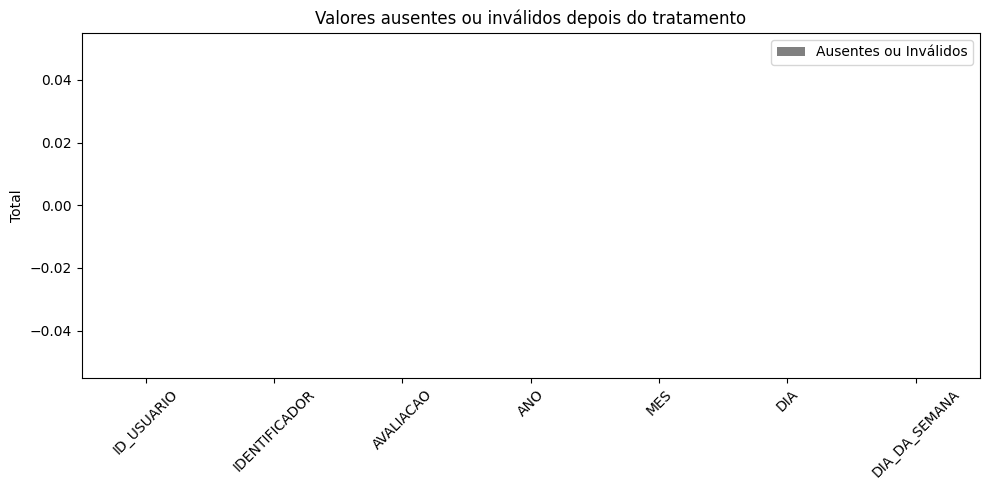

In [ ]:
# Gera um gráfico de barras para os valores ausentes
empties = dfRatings.apply(lambda col: col.map(lambda x: str(x).strip() == '') if col.dtype == 'object' else 0).sum()

nulls = dfRatings.isnull().sum()
missing_total = nulls + empties

df_nulls = pd.DataFrame({'Ausentes ou Inválidos': missing_total})
df_nulls.plot(kind='bar', figsize=(10, 5), color='gray')
plt.title('Valores ausentes ou inválidos depois do tratamento')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


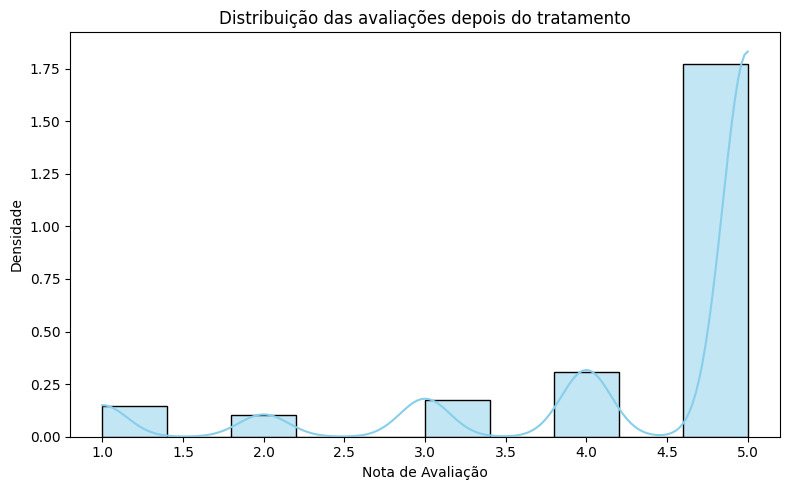

In [ ]:
# Gera um gráfico de barras para as avaliações
plt.figure(figsize=(8, 5))
sns.histplot(dfRatings['AVALIACAO'], bins=10, kde=True, stat='density', color='skyblue')
plt.title('Distribuição das avaliações depois do tratamento')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Densidade')
plt.tight_layout()
plt.show()